Fine-tuning the SAM (Segment-Anything-Model) for river water segmentation proves to be a seamless process under the expert modifications by Armin Moghimi. His enhancements enable the model to effortlessly accommodate the original image size, eliminating the need for resizing to 512x512 dimensions. The removal of this constraint empowers the adapted SAM model with heightened flexibility in handling diverse image dimensions, not only optimizing river water segmentation but also extending its capabilities to enhance performance across various segmentation tasks. Armin Moghimi's adept modifications and rewrites of the code, originally authored by **Alexandre Bonnet** and freely available for fine-tuning (https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/), showcase an unparalleled synergy that unlocks greater potential and versatility in segmentation applications beyond the realm of river water.


Moreover, I would like to express my sincere appreciation to **Alexandre Bonnet** and **Piotr Skalski** for their excellent tutorials and blog posts on SAM segmentation. Their work significantly helped me in rewriting and modifying the fine-tuning process.










In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# common
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from numpy import zeros
from numpy.random import randint
import torch
import os
import cv2
from statistics import mean
from torch.nn.functional import threshold, normalize
# Data Viz
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamPredictor, sam_model_registry
import torch.nn.functional as F

Import segment_anything and its dependency

In [ ]:
# ! pip install torch torchvision &> /dev/null
# ! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
# ! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth &> /dev/null

In [ ]:
# get the checkpoints
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth &> /dev/null

Improt Training data



In [2]:
base_dir="Data/nasa_sar_manual_download"
folder_names=os.listdir(base_dir)
folder_names.remove('.DS_Store')
folder_names.sort()
print(folder_names)

['bangladesh_20170314t115609', 'bangladesh_20170606t115613', 'bangladesh_20170712t115615', 'florence_20180510t231343', 'florence_20180522t231344', 'florence_20180603t231344', 'florence_20180615t231345', 'florence_20180709t231346', 'florence_20180721t231347', 'florence_20180802t231348', 'florence_20180907t231350', 'florence_20180919t231350', 'florence_20181001t231350', 'northal_20190302t234651', 'northal_20190419t234652', 'northal_20190513t234653', 'northal_20190606t234654', 'northal_20190724t234657', 'northal_20190805t234658', 'northal_20190829t234659', 'northal_20191004t234700', 'northal_20191121t234700', 'northal_20191227t234659', 'redrivernorth_20190104t002247', 'redrivernorth_20190116t002247', 'redrivernorth_20190128t002246', 'redrivernorth_20190209t002246', 'redrivernorth_20190317t002246', 'redrivernorth_20190410t002246', 'redrivernorth_20190621t002250']


In [3]:
training_ids = [
   'bangladesh_20170314t115609',
   'florence_20180510t231343',
   'florence_20180522t231344',
   'florence_20180603t231344',
   'florence_20180615t231345',
   'florence_20180709t231346',
   'florence_20180721t231347',
   'florence_20180802t231348',
   'northal_20190302t234651',
   'northal_20190419t234652',
   'northal_20190513t234653',
   'northal_20190606t234654',
   'northal_20190724t234657',
   'northal_20190805t234658',
   'redrivernorth_20190104t002247',
   'redrivernorth_20190116t002247',
   'redrivernorth_20190128t002246',
   'redrivernorth_20190209t002246',
   'redrivernorth_20190317t002246',
]
validation_ids=[
    'bangladesh_20170606t115613',
    'florence_20180907t231350',
    'northal_20190829t234659',
    'northal_20191004t234700',
    'redrivernorth_20190410t002246',
]
test_ids=[
    'bangladesh_20170712t115615',
    'florence_20180919t231350',
    'florence_20181001t231350',
    'northal_20191121t234700',
    'northal_20191227t234659',
    'redrivernorth_20190621t002250',
]

In [4]:
train_image_paths=[]
train_label_paths=[]
for ids in training_ids:
    image_paths=sorted(glob(f'{base_dir}/{ids}/images' + "/*.tif"))
    label_paths=sorted(glob(f'{base_dir}/{ids}/labels' + "/*.tif"))
    train_image_paths=train_image_paths+image_paths
    train_label_paths=train_label_paths+label_paths

# image_path = "Data/arcgis_SAR_SAM/Train/images"
# # total_images = len(os.listdir(image_path))
# all_image_paths = sorted(glob(image_path + "/*.tif"))
# # print(all_image_paths)
# print(f"Total Number of Images : {len(all_image_paths)}")

# lable_path = "Data/arcgis_SAR_SAM/Train/labels"
# # total_lables = len(os.listdir(lable_path))
# all_lable_paths = sorted(glob(lable_path + "/*.tif"))
# # print(all_lable_paths)
# print(f"Total Number of Images : {len(all_lable_paths)}")
# # train_image_paths = all_image_paths[0:total_images]
# # train_lable_paths = all_lable_paths[0:total_lables]
# train_image_paths = all_image_paths
# train_lable_paths = all_lable_paths

Improt Validation data

In [5]:
val_image_paths=[]
val_label_paths=[]
for ids in validation_ids:
    image_paths=sorted(glob(f'{base_dir}/{ids}/images' + "/*.tif"))
    label_paths=sorted(glob(f'{base_dir}/{ids}/labels' + "/*.tif"))
    val_image_paths=val_image_paths+image_paths
    val_label_paths=val_label_paths+label_paths

print("Total validation images: ", len(val_image_paths))

# image_path = "Data/arcgis_SAR_SAM/Val/images"
# # Val_total_images = len(os.listdir(image_path))
# all_image_paths = sorted(glob(image_path + "/*.tif"))
# # print(len(all_image_paths))
# print(f"Total Number of Images : {len(all_image_paths)}")
# lable_path = "Data/arcgis_SAR_SAM/Val/labels"
# # Val_total_lables = len(os.listdir(lable_path))
# all_lable_paths = sorted(glob(lable_path + "/*.tif"))
# # print(len(all_lable_paths))
# print(f"Total Number of Images : {len(all_lable_paths)}")
# # Val1_image_paths = all_image_paths[0:Val_total_images]
# # Val1_lable_paths = all_lable_paths[0:Val_total_lables]
# Val1_image_paths = all_image_paths
# Val1_lable_paths = all_lable_paths

Total validation images:  286


Reading ground_truth_masks for training and Validation

In [6]:
# sample_image=cv2.imread(train_lable_paths[0], cv2.IMREAD_GRAYSCALE)
# print(sample_image.shape)
# Please dont run this line if you would like to use the original size of input images.
desired_size=(400, 400)
# desired_size=(512, 512)

In [7]:
ground_truth_masks = {}
for k in range(0, len(train_image_paths)):
    # gt_grayscale = cv2.imread(train_lable_paths[k], cv2.IMREAD_GRAYSCALE)
    gt_grayscale = cv2.imread(train_label_paths[k], cv2.IMREAD_UNCHANGED)
    gt_grayscale[gt_grayscale == 1] = 255
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masks[k] = (gt_grayscale > 0)

In [8]:
ground_truth_masks_val = {}
for s in range(0, len(val_label_paths)):
    # gt_grayscale = cv2.imread(Val1_lable_paths[s], cv2.IMREAD_GRAYSCALE)
    gt_grayscale = cv2.imread(val_label_paths[s], cv2.IMREAD_UNCHANGED)
    gt_grayscale[gt_grayscale == 1] = 255
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masks_val[s] = (gt_grayscale > 0)

Import SAM model

In [9]:
# model_type = 'vit_b'
# checkpoint = 'sam_vit_b_01ec64.pth'
# device = 'cuda:0'

model_type = 'vit_l'
checkpoint = 'sam_vit_l_0b3195.pth'
# device = 'cuda:0'

# model_type = "vit_h"
# sam_checkpoint = "sam_vit_h_4b8939.pth"
# device = 'cuda:0'

In [10]:
from peft import LoraConfig, get_peft_model
sam = sam_model_registry[model_type](checkpoint=checkpoint)
# sam_model.print_trainable_parameters()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# sam_model.to(device)

# Define LoRA config
lora_config = LoraConfig(
    r=8,  # Rank of LoRA layers
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout for regularization
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to attention layers
)

# Convert SAM model to a LoRA-adapted model
sam_lora = get_peft_model(sam, lora_config)
sam_lora.print_trainable_parameters()
sam_lora.train()
sam_lora.to(device)

/Users/rabinatwayana/Rabina/anaconda3/envs/sam_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 47,104 || all params: 312,389,936 || trainable%: 0.0151


PeftModel(
  (base_model): LoraModel(
    (model): Sam(
      (image_encoder): ImageEncoderViT(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (blocks): ModuleList(
          (0-23): 24 x Block(
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=1024, out_features=3072, bias=True)
              (proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (lin1): Linear(in_features=1024, out_features=4096, bias=True)
              (lin2): Linear(in_features=4096, out_features=1024, bias=True)
              (act): GELU(approximate='none')
            )
          )
        )
        (neck): Sequential(
          (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

#mobile_sam

In [11]:
def visualize(images, masks):
    """
    Plot images and their corresponding masks in a grid
    """
    n = len(images)
    plt.figure(figsize=(10, 4 * n))

    for idx, (image, mask) in enumerate(zip(images, masks)):
        # image = image.cpu().numpy()
        plt.subplot(n, 2, 2 * idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Image {idx+1}", fontsize=12)
        plt.imshow(image)
        # mask = mask.cpu().numpy()
        plt.subplot(n, 2, 2 * idx + 2)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Mask {idx+1}", fontsize=12)
        plt.imshow(mask, cmap='gray')

    plt.show()

def visualize3(rgb_img,images, masks):
    """
    Plot images and their corresponding masks in a grid
    """
    n = len(images)
    plt.figure(figsize=(10, 4 * n))

    for idx, (rgb, image, mask) in enumerate(zip(rgb_img,images, masks)):
        plt.subplot(n, 3, 3 * idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Mask {idx+1}", fontsize=12)
        plt.imshow(rgb,cmap='gray') 
    
        # image = image.cpu().numpy()
        plt.subplot(n, 3, 3 * idx + 2)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Image {idx+1}", fontsize=12)
        plt.imshow(image,cmap='gray')
        # mask = mask.cpu().numpy()
      

        plt.subplot(n, 3, 3 * idx + 3)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Mask {idx+1}", fontsize=12)
        plt.imshow(mask, cmap='gray')

    plt.show()

#Step 1: Preprocess the images for training

> Indented block




In [ ]:
# from collections import defaultdict
# from segment_anything.utils.transforms import ResizeLongestSide

# transformed_data = defaultdict(dict)
# for k in range(len(train_image_paths)):  # Fix the loop iteration
#     image = cv2.imread(train_image_paths[k])
#     if image is None:
#         print(f"Error: Unable to read image at {image_path}")
#     print(k,image_path)
#     if desired_size is not None:
#         image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transform = ResizeLongestSide(sam_model.image_encoder.img_size)
#     input_image = transform.apply_image(image)
#     input_image_torch = torch.as_tensor(input_image, device=device)
#     transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

#     input_image = sam_model.preprocess(transformed_image)
#     original_image_size = image.shape[:2]
#     input_size = tuple(transformed_image.shape[-2:])

#     transformed_data[k]['image'] = input_image
#     transformed_data[k]['input_size'] = input_size
#     transformed_data[k]['original_image_size'] = original_image_size

In [ ]:
# from collections import defaultdict
# import cv2
# import torch
# from segment_anything.utils.transforms import ResizeLongestSide

# transformed_data = defaultdict(dict)

# for k in range(len(train_image_paths)):  
#     image_path = train_image_paths[k]  # Get image path
#     image = cv2.imread(image_path)

#     if image is None:
#         print(f"Error: Unable to read image at {image_path}")
#         continue  # Skip this iteration

#     print(f"Processing {k}: {image_path}")

#     if desired_size is not None:
#         image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     transform = ResizeLongestSide(sam_model.image_encoder.img_size)
#     input_image = transform.apply_image(image)
#     input_image_torch = torch.as_tensor(input_image, device=device)
#     transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

#     input_image = sam_model.preprocess(transformed_image)
#     original_image_size = image.shape[:2]
#     input_size = tuple(transformed_image.shape[-2:])

#     transformed_data[k]['image'] = input_image
#     transformed_data[k]['input_size'] = input_size
#     transformed_data[k]['original_image_size'] = original_image_size

# print("Transformation complete.")


In [13]:
import rasterio
import torch
from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = {}

for k in range(len(train_image_paths)):  
    image_path = train_image_paths[k]  

    # Open image using Rasterio
    with rasterio.open(image_path) as dataset:
        image = dataset.read().astype("float32")  # Convert to float32

    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image = transform.apply_image(image.transpose(1, 2, 0))  # Convert (Bands, H, W) -> (H, W, Bands)

    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam.preprocess(transformed_image)
    original_image_size = image.shape[1:]  # (Height, Width)
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k] = {
        "image": input_image,
        "input_size": input_size,
        "original_image_size": original_image_size,
    }

print("Transformation complete.")


/Users/rabinatwayana/Rabina/anaconda3/envs/sam_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


Transformation complete.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


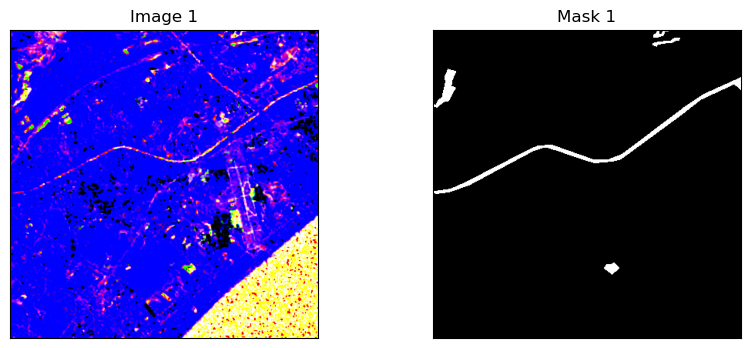

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


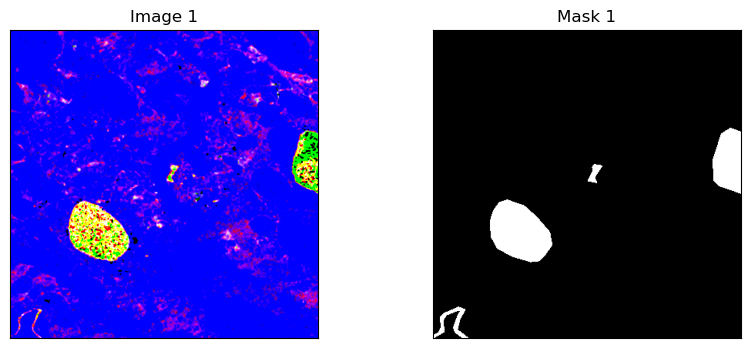

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


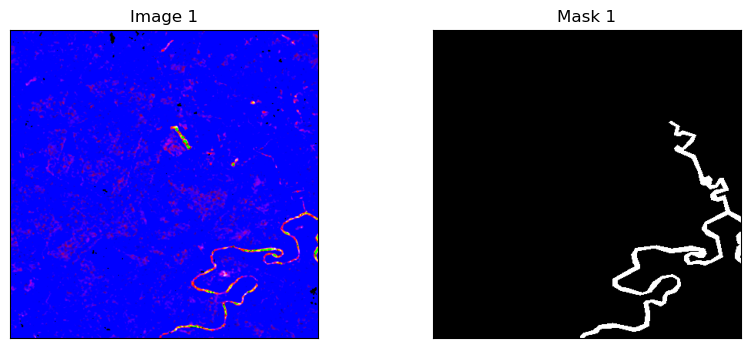

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


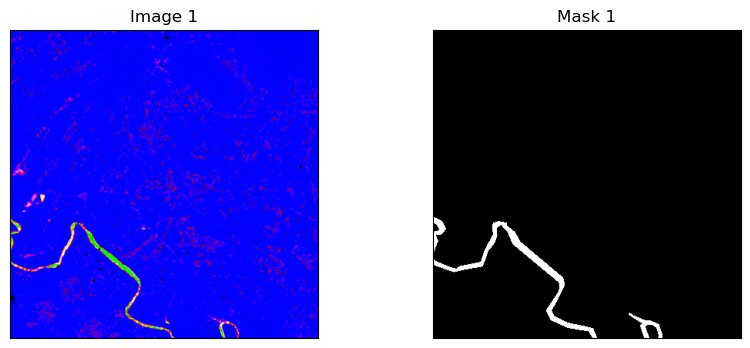

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877125].


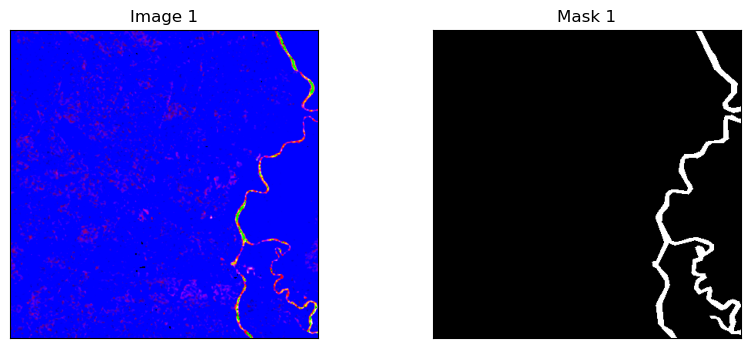

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


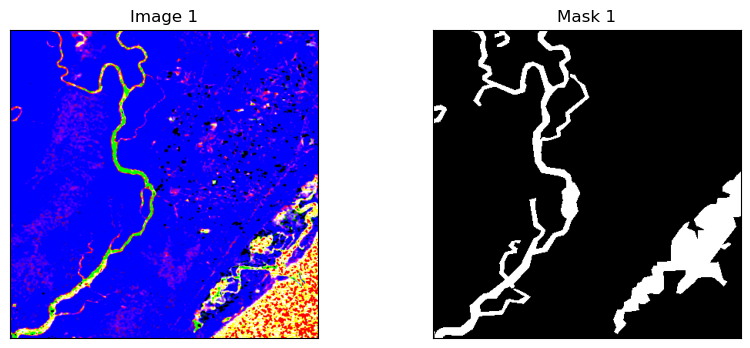

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


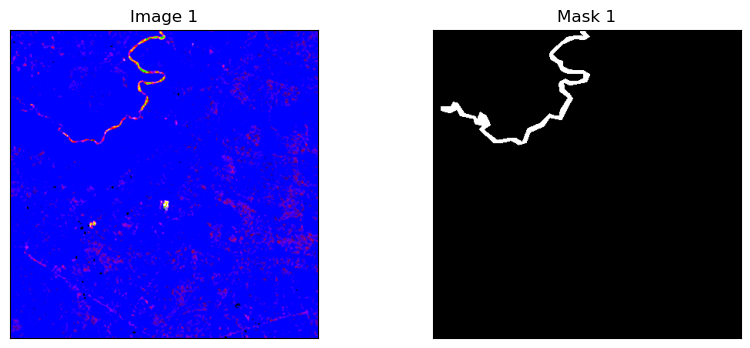

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


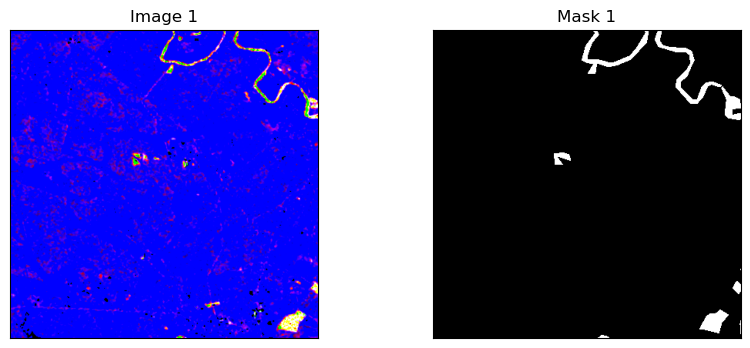

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


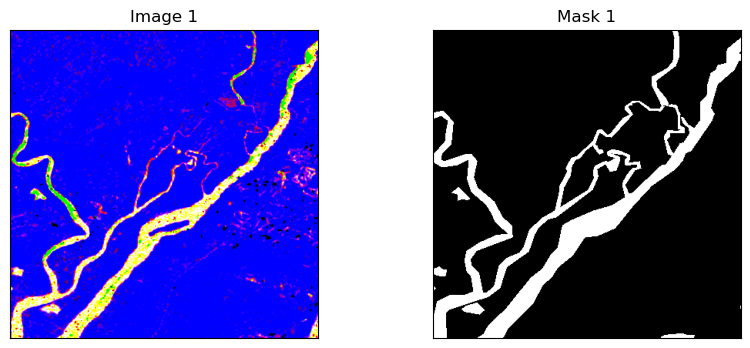

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


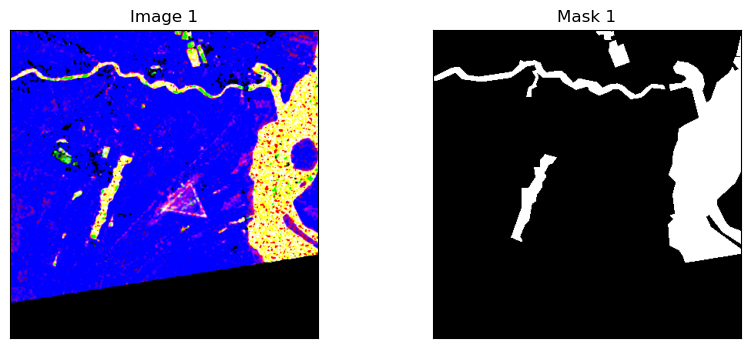

In [14]:
for  i in list(transformed_data.keys())[400:410]:
    image = transformed_data[i]['image']
    ground_truth_mask = ground_truth_masks[i]
    
    if image.device != 'cpu':
        image = image.cpu()
    if ground_truth_mask.device != 'cpu':
        ground_truth_mask = ground_truth_mask.cpu()
    image = image.squeeze(0)  # Removes the first dimension (if batch size is 1)
    
    # Convert to NumPy and transpose if needed (for HWC format)
    image = image.permute(1, 2, 0).numpy() 
    visualize([image], [ground_truth_mask])
    


# Set up the optimizer, and Loss


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# # Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',    # Can use 'val_accuracy' if preferred
#     patience=5,            # Stop training after 5 epochs of no improvement
#     restore_best_weights=True,  # Restore the best weights from the epoch with the lowest validation loss
#     verbose=1              # Print messages when early stopping is triggered
# )

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


In [15]:
lr = 5e-5
wd = 1e-4 
optimizer = torch.optim.Adam(sam_lora.mask_decoder.parameters(), lr=lr, weight_decay=wd)
loss_fn   = torch.nn.BCEWithLogitsLoss()

keys = list(ground_truth_masks.keys())
keys1 = list(ground_truth_masks_val.keys())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define batch size
batch_size = 64
num_epochs = 5

# Early Stopping & LR Reduction Parameters
patience = 3  # Number of epochs to wait for improvement
lr_factor = 0.5  # Factor by which to reduce LR
min_lr = 1e-5  # Minimum learning rate
best_val_loss = float('inf')  # Track best validation loss
early_stop_counter = 0  #



def dice_loss(pred, target, smooth=1e-6):
    """
    Computes the Dice Loss.
    
    Args:
        pred (torch.Tensor): Predicted segmentation mask (logits or probabilities).
        target (torch.Tensor): Ground truth mask.
        smooth (float): Smoothing term to prevent division by zero.

    Returns:
        torch.Tensor: Dice loss value.
    """
    pred = torch.sigmoid(pred)  # Ensure predictions are in range [0,1]
    
    intersection = (pred * target).sum(dim=(1, 2, 3))  # Sum over spatial dimensions
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))  # Sum both masks
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()  #

In [16]:
print(len(keys)/batch_size)

14.625


# Fine tuning SAM by Training data

In [ ]:
def train_on_batch(keys, batch_start, batch_end):
    batch_losses = []
    batch_accuracies = []

    for k in keys[batch_start:batch_end]:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

        # No grad here as we don't want to optimize the encoders
        with torch.no_grad():
            image_embedding = sam_lora.image_encoder(input_image)

            sparse_embeddings, dense_embeddings = sam_lora.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )

        low_res_masks, iou_predictions = sam_lora.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_lora.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        upscaled_masks = sam_lora.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        # print(np.unique(upscaled_masks.cpu().detach().numpy()),"upscaled mask")
        
        binary_mask = (threshold(torch.sigmoid(upscaled_masks), 0.5, 0))
        # print(np.unique(binary_mask.cpu().detach().numpy()),"______")
        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
        gt_mask_resized = gt_mask_resized > 0.5
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

        alpha=0.7
        bce = loss_fn(binary_mask, gt_binary_mask)
        dice = dice_loss(upscaled_masks, gt_binary_mask)
        
        # loss = dice #+ bce  # Combined Loss (Dice + BCE)
        loss=(alpha*bce)+((1-alpha)*dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        # Calculate accuracy for training data
        train_accuracy = calculate_accuracy(binary_mask, gt_binary_mask)
        batch_accuracies.append(train_accuracy)

    return batch_losses, batch_accuracies

def calculate_accuracy(predictions, targets):
    binary_predictions = (predictions > 0.5).float()
    accuracy = (binary_predictions == targets).float().mean()
    return accuracy.item()

losses = []
val_losses = []
accuracies = []
best_val_loss = float('inf')  # Initialize best validation loss to positive infinity
val_acc = []

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []

    # Training loop with batch processing
    for batch_start in range(0, len(keys), batch_size):
       
        batch_end = min(batch_start + batch_size, len(keys))

        batch_losses, batch_accuracies = train_on_batch(keys, batch_start, batch_end)

        # Calculate accuracy for the current batch
        batch_accuracy = round(mean(batch_accuracies),4)
        epoch_accuracies.extend(batch_accuracies)

        # Calculate mean training loss for the current batch
        batch_loss = round(mean(batch_losses),4)
        epoch_losses.append(batch_loss)

        print(f'Batch: [{batch_start+1}-{batch_end}]')
        print(f'Batch Loss: {batch_loss}')
        print(f'Batch Accuracy: {batch_accuracy}')
        # break

    # Calculate mean training loss for the current epoch
    mean_train_loss = round(mean(epoch_losses),4)
    mean_train_accuracy = round(mean(epoch_accuracies),4)
    losses.append(mean_train_loss)
    accuracies.append(mean_train_accuracy)

    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean_train_loss}')
    print(f'Mean training accuracy: {mean_train_accuracy}')

    predictor_tuned = SamPredictor(sam_lora)

    # Validation loop
    val_loss = 0.0
    val_accuracy = 0.0
    num_val_examples = 0
    with torch.no_grad():
        for s in keys1[:len(val_image_paths)]:  # Replace validation_keys with your validation data keys
            # image = cv2.imread(Val1_image_paths[s])
            # if desired_size is not None:
            #    image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            with rasterio.open(val_image_paths[s]) as dataset:
                image = dataset.read([1,2,3]).astype("float32")  # Convert to float32
            image = image.transpose(1, 2, 0)

            # Forward pass on validation data
            predictor_tuned.set_image(image)

            masks_tuned, _, _ = predictor_tuned.predict(
                point_coords=None,
                box=None,
                multimask_output=False,
            )

            gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks_val[s], (1, 1, ground_truth_masks_val[s].shape[0], ground_truth_masks_val[s].shape[1]))).to(device)
            gt_mask_resized = gt_mask_resized > 0.5
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
            masks_tuned1 = torch.as_tensor(masks_tuned > 0, dtype=torch.float32)
            new_tensor = masks_tuned1.unsqueeze(0).to(device)

            # Calculate validation loss
            # val_loss += loss_fn(new_tensor, gt_binary_mask).item()

            alpha=0.7
            bce = loss_fn(new_tensor, gt_binary_mask)
            dice = dice_loss(new_tensor, gt_binary_mask)
            loss=(alpha*bce)+((1-alpha)*dice)
            val_loss += loss.item()

            # Calculate accuracy for validation data
            val_accuracy += calculate_accuracy(new_tensor, gt_binary_mask)
            num_val_examples += 1

    # Calculate mean validation loss for the current epoch
    val_loss = round((val_loss/ num_val_examples) ,4)
    val_losses.append(val_loss)
    print(f'Mean validation loss: {val_loss}')

    # Calculate mean validation accuracy for the current epoch
    mean_val_accuracy = round((val_accuracy / num_val_examples),4)
    val_acc.append(mean_val_accuracy)
    print(f'Mean validation accuracy: {mean_val_accuracy}')

    # Save the model checkpoint if the validation accuracy improves
    if round(val_loss,4) < round(best_val_loss,4):
        best_val_loss = val_loss
        models_path = 'checkpoints_LORA'
        torch.save(sam_lora.state_dict(), os.path.join(models_path,f'{epoch}_SAM5122weights_ViT_L_SAR.pth'))
    else:
        early_stop_counter += 1
        print(f"🚨 No Improvement. Early Stop Counter: {early_stop_counter}/{patience}")

    # **ReduceLROnPlateau**
    if early_stop_counter >= patience:
        new_lr = max(optimizer.param_groups[0]['lr'] * lr_factor, min_lr)
        if new_lr == optimizer.param_groups[0]['lr']:
            print("🛑 Early Stopping Triggered! Stopping Training.")
            break
        print(f"🔽 Reducing Learning Rate to {new_lr:.7f}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

    # Clear GPU cache after each epoch
    torch.mps.empty_cache()


Batch: [1-64]
Batch Loss: 0.7287
Batch Accuracy: 0.7642
Batch: [65-128]
Batch Loss: 0.7765
Batch Accuracy: 0.8257
Batch: [129-192]
Batch Loss: 0.7583
Batch Accuracy: 0.8653
Batch: [193-256]
Batch Loss: 0.7445
Batch Accuracy: 0.8971
Batch: [257-320]
Batch Loss: 0.6827
Batch Accuracy: 0.922
Batch: [321-384]
Batch Loss: 0.6487
Batch Accuracy: 0.9335
Batch: [385-448]
Batch Loss: 0.6418
Batch Accuracy: 0.9251
Batch: [449-512]
Batch Loss: 0.6104
Batch Accuracy: 0.9345
Batch: [513-576]
Batch Loss: 0.5924
Batch Accuracy: 0.93
Batch: [577-640]
Batch Loss: 0.5792
Batch Accuracy: 0.9464
Batch: [641-704]
Batch Loss: 0.5477
Batch Accuracy: 0.9618
Batch: [705-768]
Batch Loss: 0.5362
Batch Accuracy: 0.9696
Batch: [769-832]
Batch Loss: 0.5116
Batch Accuracy: 0.9807
Batch: [833-896]
Batch Loss: 0.6675
Batch Accuracy: 0.8755
Batch: [897-936]
Batch Loss: 0.7173
Batch Accuracy: 0.8291
EPOCH: 0
Mean training loss: 0.6496
Mean training accuracy: 0.906


/Users/rabinatwayana/Rabina/anaconda3/envs/sam_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


Mean validation loss: 0.7286
Mean validation accuracy: 0.908
Batch: [1-64]
Batch Loss: 0.629
Batch Accuracy: 0.8403
Batch: [65-128]
Batch Loss: 0.6389
Batch Accuracy: 0.931
Batch: [129-192]
Batch Loss: 0.6389
Batch Accuracy: 0.9242
Batch: [193-256]
Batch Loss: 0.6143
Batch Accuracy: 0.9374
Batch: [257-320]
Batch Loss: 0.5804
Batch Accuracy: 0.9549
Batch: [321-384]
Batch Loss: 0.5927
Batch Accuracy: 0.955
Batch: [385-448]
Batch Loss: 0.6089
Batch Accuracy: 0.9376
Batch: [449-512]
Batch Loss: 0.5375
Batch Accuracy: 0.9731
Batch: [513-576]
Batch Loss: 0.5182
Batch Accuracy: 0.9704
Batch: [577-640]
Batch Loss: 0.5119
Batch Accuracy: 0.9819
Batch: [641-704]
Batch Loss: 0.5051
Batch Accuracy: 0.982
Batch: [705-768]
Batch Loss: 0.5137
Batch Accuracy: 0.9787
Batch: [769-832]
Batch Loss: 0.4966
Batch Accuracy: 0.9853
Batch: [833-896]
Batch Loss: 0.6516
Batch Accuracy: 0.8807
Batch: [897-936]
Batch Loss: 0.7115
Batch Accuracy: 0.8254
EPOCH: 1
Mean training loss: 0.5833
Mean training accuracy: 0.

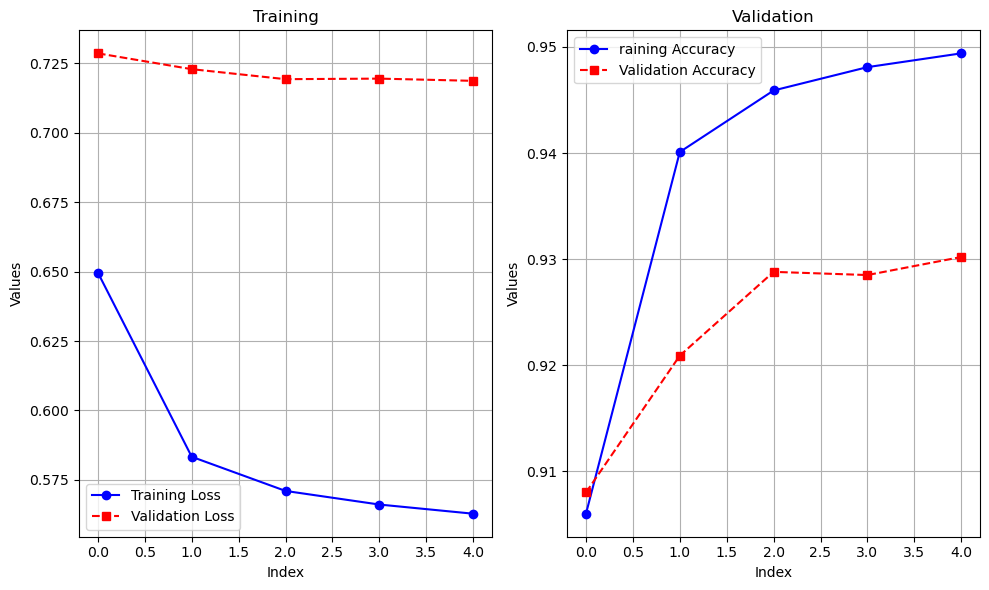

In [ ]:

# Generate x-axis using the index of the lists
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # 2 rows, 1 column
epoch_x = range(len(losses))  # [0, 1, 2, 3, 4]
# Plot the two lists
axs[0].plot(epoch_x, losses, marker='o', linestyle='-', color='b', label="Training Loss")
axs[0].plot(epoch_x, val_losses, marker='s', linestyle='--', color='r', label="Validation Loss")

# Labels and title
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Values")
axs[0].set_title("Training")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epoch_x, accuracies, marker='o', linestyle='-', color='b', label="Training Accuracy")
axs[1].plot(epoch_x, val_acc, marker='s', linestyle='--', color='r', label="Validation Accuracy")

# Labels and title
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Values")
axs[1].set_title("Validation")
axs[1].legend()
axs[1].grid(True)

# Show the graph
# plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# for s in keys1[:len(Val1_image_paths)]:  # Replace validation_keys with your validation data keys
            
#    # Open image using Rasterio
#     with rasterio.open(Val1_image_paths[s]) as dataset:

#         image = dataset.read([1,2,3]).astype("float32")  # Convert to float32
#         print("Number of bands:", dataset.count)
#         print("Image shape:", image.shape) 
#     break


            # image = cv2.imread(Val1_image_paths[s])
            # if desired_size is not None:
            #    image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Step 3: Testing fine-tuned SAM model

In [ ]:
test_image_paths=[]
test_label_paths=[]
for ids in test_ids:
    image_paths=sorted(glob(f'{base_dir}/{ids}/images' + "/*.tif"))
    label_paths=sorted(glob(f'{base_dir}/{ids}/labels' + "/*.tif"))
    test_image_paths=test_image_paths+image_paths
    test_label_paths=test_label_paths+label_paths
print(f"Total Number of Test Images : {len(test_image_paths)}")


# image_path = "Data/arcgis_SAR_SAM/Test/images"
# # test_total_images = len(os.listdir(image_path))
# Test_image_paths = sorted(glob(image_path + "/*.tif"))
# print(f"Total Number of Test Images : {len(Test_image_paths)}")

# lable_path = "Data/arcgis_SAR_SAM/Test/labels"
# # test_total_lables = len(os.listdir(lable_path))
# Test_lable_paths = sorted(glob(lable_path + "/*.tif"))
# print(f"Total Number of Test Images : {len(Test_lable_paths)}")
# # Test_image_paths = all_image_paths[0:test_total_images]
# # Test_lable_paths = all_lable_paths[0:test_total_lables]

# # Test_image_paths = all_image_paths
# # Test_lable_paths = all_lable_paths

Box for Test *data*

Ground_truth_test_masks

In [ ]:
# gt_grayscale = cv2.imread(train_lable_paths[k], cv2.IMREAD_UNCHANGED)
#     gt_grayscale[gt_grayscale == 1] = 255
# with rasterio.open(Val1_image_paths[s]) as dataset:
#                 image = dataset.read([1,2,3]).astype("float32")  # Convert to float32
#             image = image.transpose(1, 2, 0)


# ground_truth_test_masks = {}
# for k in range(0, len(all_image_paths)):
#     with rasterio.open(Test_lable_paths[k]) as dataset:
#           gt_grayscale = dataset.read([1]).astype(np.float32)
#     # gt_grayscale=gt_grayscale.squeeze(0)
#     # gt_grayscale = cv2.imread(Test_lable_paths[k])
#     ground_truth_test = (gt_grayscale[:,:,2]>0).astype(np.float32)
#     # ground_truth_test = (gt_grayscale[:,:,2]>0).astype(np.float32)

#     # if desired_size is not None:
#     #     ground_truth_test = cv2.resize(ground_truth_test, desired_size, interpolation=cv2.INTER_NEAREST)

#     ground_truth_test_masks[k] = (ground_truth_test).astype(np.float32)

In [ ]:

ground_truth_test_masks = {}
for k in range(0, len(test_label_paths)):
#   gt_grayscale = cv2.imread(Test_lable_paths[k])
    with rasterio.open(test_label_paths[k]) as dataset:
        gt_grayscale = dataset.read([1]).astype(np.float32)
        # print(gt_grayscale.shape,"gt_grayscale")
        gt_grayscale = np.transpose(gt_grayscale, (1, 2, 0)) 
    # ground_truth_test = (gt_grayscale[:,:,2]>0).astype(np.float32)
    #   if desired_size is not None:
    #       ground_truth_test = cv2.resize(ground_truth_test, desired_size, interpolation=cv2.INTER_NEAREST)

    ground_truth_test_masks[k] = (gt_grayscale).astype(np.float32)

# print(ground_truth_test_masks[1].shape)
    

In [ ]:
# ground_truth_test_masks

Load the trained model with best parameters

In [ ]:
len(test_label_paths)

Prediction using Fine_tuned model

In [ ]:
# with rasterio.open(Test_lable_paths[k]) as dataset:
    #       image = dataset.read(1).astype(np.float32)
    # Load the image and convert color space

masks_tuned_list = {}
images_tuned_list= {}
for k in range(0, len(test_label_paths)):

    with rasterio.open(test_image_paths[k]) as dataset:
        image = dataset.read([1, 2, 3]).astype(np.float32)  # Read first 3 bands
        image = np.transpose(image, (1, 2, 0))  # Convert (Bands, Height, Width) → (Height, Width, Bands)
    
    # image = cv2.cvtColor(cv2.imread(Test_image_paths[k]), cv2.COLOR_BGR2RGB)
    # if desired_size is not None:
    #    image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    predictor_tuned.set_image(image)

    # Perform prediction using predictor_tuned object
    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=None,
        multimask_output=False,
    )

    # Get the first mask from the predictions
    kk = masks_tuned[0, :, :]
    binary_mask = (kk > 0).astype(np.float32)
    # Resize the mask to the desired dimensions using nearest neighbor interpolation
    images_tuned_list[k]  = image
    masks_tuned_list[k]  = binary_mask

In [ ]:
# print(type(images_tuned_list))
# print(type(masks_tuned_list))
# with rasterio.open(Test_image_paths[1]) as dataset:
#         image = dataset.read([1, 2, 3]).astype(np.float32)  # Read first 3 bands
#         image = np.transpose(image, (1, 2, 0))  # Convert (Bands, Height, Width) → (Height, Width, Bands)
# visualize([image],[image])

In [ ]:
len(images_tuned_list)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_map(predictions_binary, targets_binary):
    # Create an empty map for visualization
    confusion_map = np.zeros_like(predictions_binary, dtype=np.uint8)
    
    # Assign different values for different cases
    confusion_map[(predictions_binary == 1) & (targets_binary == 1)] = 1  # TP (Green)
    confusion_map[(predictions_binary == 1) & (targets_binary == 0)] = 2  # FP (Red)
    confusion_map[(predictions_binary == 0) & (targets_binary == 1)] = 3  # FN (Blue)
    confusion_map[(predictions_binary == 0) & (targets_binary == 0)] = 0  # TN (Black)

    # Define a custom colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(["black", "green", "red", "blue"])
    
    # Plot the confusion map
    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_map, cmap=cmap, interpolation="nearest")
    
    # Create a color legend
    from matplotlib.patches import Patch
    legend_patches = [
        Patch(color="black", label="TN (True Negative)"),
        Patch(color="green", label="TP (True Positive)"),
        Patch(color="red", label="FP (False Positive)"),
        Patch(color="blue", label="FN (False Negative)"),
    ]
    
    plt.legend(handles=legend_patches, loc="upper right", fontsize=10)
    plt.title("Confusion Map: TP, FP, TN, FN")
    plt.axis("off")
    plt.show()


Plot results on all of the Test data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming images_tuned_list and masks_binary_list are lists of RGB images and binary masks, respectively

# Create a 12x20 subplot grid
# fig, axs = plt.subplots(12, 20, figsize=(20, 12))

# # Iterate over rows and columns
# for i in range(12):
#     for j in range(20):
#         # Calculate the index for images_tuned_list and masks_binary_list
#         index = i * 20 + j

        # Check if index is within the range of your data
        # if index < len(images_tuned_list):
for index in range(len(images_tuned_list)):
    # Display the RGB image
    # axs[i, j].imshow(images_tuned_list[index], interpolation='none')

    # Create a blue mask with alpha channel
    blue_mask = np.zeros_like(masks_tuned_list[index])
    blue_mask[masks_tuned_list[index] == 1] = 1
    blue_mask_rgb = np.stack([np.zeros_like(blue_mask), np.zeros_like(blue_mask), blue_mask], axis=-1)

    with rasterio.open(test_label_paths[index]) as dataset:
        gt_grayscale = dataset.read([1]).astype(np.float32)
        gt_grayscale = np.transpose(gt_grayscale, (1, 2, 0)) 

    with rasterio.open(test_image_paths[index]) as dataset:
        image = dataset.read([1,2,3]).astype(np.float32)
        transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        input_image = transform.apply_image(image.transpose(1, 2, 0))  # Convert (Bands, H, W) -> (H, W, Bands)

        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

        input_image = sam_model.preprocess(transformed_image)
        if input_image.device != 'cpu':
            input_image = input_image.cpu()
        image = input_image.squeeze(0)  # Removes the first dimension (if batch size is 1)
    
        # Convert to NumPy and transpose if needed (for HWC format)
        image = image.permute(1, 2, 0).numpy() 
        # rgb_image = np.transpose(rgb_image, (1, 2, 0)) 

    # Overlay the blue mask on the RGB image
    visualize3([image],[gt_grayscale],[blue_mask_rgb])

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import auc, roc_curve
np.set_printoptions(threshold=np.inf)
def binary_segmentation_metrics(predictions, targets):
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.squeeze()
    targets_binary = (targets_binary > 0.5).astype(int)
    # plot_confusion_map(predictions_binary, targets_binary)


    # Convert torch tensors to numpy arrays
    # Convert torch tensors to numpy arrays
    # predictions = predictions
    # targets = targets
    # Convert predictions to binary values (0 or 1)
   
    # print(predictions_binary.shape,targets_binary.shape)
    # print(np.unique(predictions_binary),"pred binary")
    # print(np.unique(targets_binary),"target binary")

    # True Positives (TP): prediction and target both are positive
    TP = np.sum((predictions_binary == 1) & (targets_binary == 1))
    # False Positives (FP): prediction is positive but target is negative
    FP = np.sum((predictions_binary == 1) & (targets_binary == 0))
    # False Negatives (FN): prediction is negative but target is positive
    FN = np.sum((predictions_binary == 0) & (targets_binary == 1))
    # True Negatives (TN): prediction and target both are negative
    TN = np.sum((predictions_binary == 0) & (targets_binary == 0))
    
    # print(f'TP:{TP}, FP:{FP}, FN:{FN},TN:{TN}')
    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def calculate_average_metrics(predictions_list, targets_list):
    num_masks = len(predictions_list)

    total_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f_score': 0.0,
        'iou': 0.0,
        'kappa': 0.0,
        'FP': 0,
        'FN': 0,
        'MAR': 0.0,
        'FAR': 0.0,
        'dice': 0.0
    }

    for i in range(num_masks):
        # visualize([predictions_list[i]], [targets_list[i]])
        
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        for metric_name, value in zip(total_metrics.keys(), metrics):
            total_metrics[metric_name] += value

        total_metrics['MAR'] += metrics[8] / (metrics[8] + metrics[9])
        total_metrics['FAR'] += metrics[6] / (metrics[9] + metrics[6])
        # break

    avg_metrics = {k: v / num_masks for k, v in total_metrics.items()}

    return avg_metrics

# Example usage

avg_metrics = calculate_average_metrics(masks_tuned_list, ground_truth_test_masks)

for metric_name, value in avg_metrics.items():
    print(f"Average {metric_name}: {value}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.color import rgb2gray
# from skimage.measure import find_contours

# Assuming images_tuned_list and masks_binary_list are lists of RGB images and binary masks, respectively
# Border parameters
border_color = 'black'
border_width = 0.35

# Create a 13x1 subplot grid for 13 images
fig, axs = plt.subplots(1, 13, figsize=(20, 10))

# Flatten the subplot grid for easy iteration
axs = axs.flatten()

# Select 13 images to display
selected_indices = [1, 57, 17, 87, 62, 13, 67, 26, 81, 98, 18, 21, 11]
# Iterate over selected indices
for i, index in enumerate(selected_indices):
    # Check if index is within the range of your data
    if index < len(images_tuned_list):
        # Display the RGB image
        gray_image = rgb2gray(images_tuned_list[index])
        axs[i].imshow(gray_image, cmap='gray', interpolation='none', alpha=0.5)  # Adjust alpha value as needed

        # Create a mask with alpha channel for segmentation result
        ground_truth_mask = (ground_truth_test_masks[index])
        mask = (masks_tuned_list[index])

        # Create a blue mask with alpha channel for true positives
        true_positive_mask = (mask == 1) & (ground_truth_mask == 1)
        blue_mask = np.stack([np.zeros_like(true_positive_mask), np.zeros_like(true_positive_mask), true_positive_mask], axis=-1)
        # Expand the true_positive_mask to have shape (H, W, 1)
        # blue_mask_rgba = np.concatenate([blue_mask, true_positive_mask[:, :, None].astype(float)], axis=-1)
        true_positive_mask_expanded = np.expand_dims(true_positive_mask.astype(float), axis=-1)
        blue_mask_rgba = np.concatenate([blue_mask, true_positive_mask_expanded], axis=-1)
        axs[i].imshow(blue_mask_rgba[0], alpha=0.50)

        # Create a yellow mask with alpha channel for false alarms
        false_alarm_mask = (mask == 1) & (ground_truth_mask == 0)
        tight_green_mask = np.stack([np.zeros_like(false_alarm_mask), false_alarm_mask, np.zeros_like(false_alarm_mask)], axis=-1)
        # tight_green_mask_rgba = np.concatenate([tight_green_mask, false_alarm_mask[:, :, None].astype(float)], axis=-1)
        false_alarm_mask_expanded = np.expand_dims(false_alarm_mask.astype(float), axis=-1)
        tight_green_mask_rgba = np.concatenate([tight_green_mask, false_alarm_mask_expanded], axis=-1)
        axs[i].imshow(tight_green_mask_rgba[0], alpha=0.60)

        # Create a red mask with alpha channel for missed alarms
        missed_alarm_mask = (mask == 0) & (ground_truth_mask == 1)
        magenta_mask = np.stack([missed_alarm_mask, np.zeros_like(missed_alarm_mask), missed_alarm_mask], axis=-1)
        # magenta_mask_rgba = np.concatenate([magenta_mask, missed_alarm_mask[:, :, None].astype(float)], axis=-1)
        missed_alarm_mask_expanded = np.expand_dims(missed_alarm_mask.astype(float), axis=-1)
        magenta_mask_rgba = np.concatenate([magenta_mask, missed_alarm_mask_expanded], axis=-1)
        axs[i].imshow(magenta_mask_rgba[0], alpha=0.60)

        # Add a black border around the image
        rect = Rectangle((0, 0), gray_image.shape[1], gray_image.shape[0], linewidth=border_width, edgecolor=border_color, facecolor='none')
        axs[i].add_patch(rect)

        # Turn off axis labels for better visualization
        axs[i].axis('off')

# Adjust layout to prevent clipping of subplot labels
plt.subplots_adjust(wspace=0.02, hspace=0.02)
# Adjust layout to prevent clipping of subplot labels
# Save the figure with 600 DPI
plt.subplots_adjust(wspace=0.02, hspace=0.02)

output_path = 'output/ViTSAML.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

Validation

In [ ]:
import numpy as np

# def binary_segmentation_metrics(predictions, targets):
#     # # Convert torch tensors to numpy arrays
#     # predictions = predictions.squeeze()
#     # targets = targets
#     # # Convert predictions to binary values (0 or 1)
#     # predictions_binary = (predictions > 0.5).astype(int)
#     # targets_binary = targets.astype(int)
#     predictions_binary = (predictions > 0.5).astype(int)
#     targets_binary = targets.squeeze()
#     targets_binary = (targets_binary > 0.5).astype(int)

#     # True Positives (TP): prediction and target both are positive
#     TP = np.sum((predictions_binary == 1) & (targets == 1))

#     # False Positives (FP): prediction is positive but target is negative
#     FP = np.sum((predictions_binary == 1) & (targets == 0))

#     # False Negatives (FN): prediction is negative but target is positive
#     FN = np.sum((predictions_binary == 0) & (targets == 1))

#     # True Negatives (TN): prediction and target both are negative
#     TN = np.sum((predictions_binary == 0) & (targets == 0))

#     eps = 1e-5
#     accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
#     precision = (TP + eps) / (TP + FP + eps)
#     recall = (TP + eps) / (TP + FN + eps)
#     f_score = 2 * (precision * recall) / (precision + recall)
#     dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
#     iou = (TP + eps) / (TP + FP + FN + eps)

#     total = TP + FP + FN + TN
#     p_o = (TP + TN) / total
#     p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
#     kappa = (p_o - p_e) / (1 - p_e)

#     return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def categorize_metric(metric_value, metric_name):
    if metric_name == 'IoU':
        if metric_value > 0.90:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.90:
            return "Good"
        elif 0.75 <= metric_value < 0.85:
            return "Fair"
        elif 0.65 <= metric_value < 0.75:
            return "Poor"
        else:
            return "Unacceptable"
    elif metric_name == 'Precision':
        if metric_value > 0.95:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.95:
            return "Good"
        elif 0.65 <= metric_value < 0.85:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Kappa':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'F-Score':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Recall':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    else:
        return "Unknown"

def calculate_metrics_for_images(predictions_list, targets_list):
    num_masks = len(predictions_list)

    all_metrics = []

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        metrics_dict = {
            'Accuracy': metrics[0],
            'Precision': metrics[1],
            'Recall': metrics[2],
            'F-Score': metrics[3],
            'IoU': metrics[4],
            'Kappa': metrics[5],
            'FP': metrics[6],
            'FN': metrics[7],
            'TP': metrics[8],
            'TN': metrics[9],
            'Dice': metrics[10],
        }

        categorized_metrics = {}
        for metric_name, value in metrics_dict.items():
            category = categorize_metric(value, metric_name)
            categorized_metrics[metric_name + '_Category'] = category

        all_metrics.append({**metrics_dict, **categorized_metrics})

    return all_metrics

# Example usage

metrics_list = calculate_metrics_for_images(masks_tuned_list, ground_truth_test_masks)

# Initialize counters for each category
excellent_count_iou = 0
good_count_iou = 0
moderate_count_iou = 0
poor_count_iou = 0
fail_count_iou = 0

excellent_count_precision = 0
good_count_precision = 0
moderate_count_precision = 0
fail_count_precision = 0

excellent_count_kappa = 0
good_count_kappa = 0
moderate_count_kappa = 0
fail_count_kappa = 0

excellent_count_fscore = 0
good_count_fscore = 0
moderate_count_fscore = 0
fail_count_fscore = 0

excellent_count_recall = 0
good_count_recall = 0
moderate_count_recall = 0
fail_count_recall = 0

for i, metrics in enumerate(metrics_list):
    for metric_name, value in metrics.items():
        # Count the category for each metric
        if metric_name.endswith('_Category'):
            category = value
            if metric_name.startswith('IoU'):
                if category == 'Excellent':
                    excellent_count_iou += 1
                elif category == 'Good':
                    good_count_iou += 1
                elif category == 'Fair':
                    moderate_count_iou += 1
                elif category == 'Poor':
                    poor_count_iou += 1
                elif category == 'Unacceptable':
                    fail_count_iou += 1
            elif metric_name.startswith('Precision'):
                if category == 'Excellent':
                    excellent_count_precision += 1
                elif category == 'Good':
                    good_count_precision += 1
                elif category == 'Moderate':
                    moderate_count_precision += 1
                elif category == 'Fail':
                    fail_count_precision += 1
            elif metric_name.startswith('Kappa'):
                if category == 'Excellent':
                    excellent_count_kappa += 1
                elif category == 'Good':
                    good_count_kappa += 1
                elif category == 'Moderate':
                    moderate_count_kappa += 1
                elif category == 'Fail':
                    fail_count_kappa += 1
            elif metric_name.startswith('F-Score'):
                if category == 'Excellent':
                    excellent_count_fscore += 1
                elif category == 'Good':
                    good_count_fscore += 1
                elif category == 'Moderate':
                    moderate_count_fscore += 1
                elif category == 'Fail':
                    fail_count_fscore += 1
            elif metric_name.startswith('Recall'):
                if category == 'Excellent':
                    excellent_count_recall += 1
                elif category == 'Good':
                    good_count_recall += 1
                elif category == 'Moderate':
                    moderate_count_recall += 1
                elif category == 'Fail':
                    fail_count_recall += 1

# Calculate percentages
total_images = len(metrics_list)

excellent_percentage_iou = (excellent_count_iou / total_images) * 100
good_percentage_iou = (good_count_iou / total_images) * 100
moderate_percentage_iou = (moderate_count_iou / total_images) * 100
poor_percentage_iou = (poor_count_iou / total_images) * 100
fail_percentage_iou = (fail_count_iou / total_images) * 100

excellent_percentage_precision = (excellent_count_precision / total_images) * 100
good_percentage_precision = (good_count_precision / total_images) * 100
moderate_percentage_precision = (moderate_count_precision / total_images) * 100
fail_percentage_precision = (fail_count_precision / total_images) * 100

excellent_percentage_kappa = (excellent_count_kappa / total_images) * 100
good_percentage_kappa = (good_count_kappa / total_images) * 100
moderate_percentage_kappa = (moderate_count_kappa / total_images) * 100
fail_percentage_kappa = (fail_count_kappa / total_images) * 100

excellent_percentage_fscore = (excellent_count_fscore / total_images) * 100
good_percentage_fscore = (good_count_fscore / total_images) * 100
moderate_percentage_fscore = (moderate_count_fscore / total_images) * 100
fail_percentage_fscore = (fail_count_fscore / total_images) * 100

excellent_percentage_recall = (excellent_count_recall / total_images) * 100
good_percentage_recall = (good_count_recall / total_images) * 100
moderate_percentage_recall = (moderate_count_recall / total_images) * 100
fail_percentage_recall = (fail_count_recall / total_images) * 100

# Print counts and percentages
print("Counts and Percentages of Images in Each Category for IoU:")
print(f"Excellent: {excellent_count_iou} ({excellent_percentage_iou}%)")
print(f"Good: {good_count_iou} ({good_percentage_iou}%)")
print(f"Moderate: {moderate_count_iou} ({moderate_percentage_iou}%)")
print(f"Poor: {poor_count_iou} ({poor_percentage_iou}%)")
print(f"Fail: {fail_count_iou} ({fail_percentage_iou}%)")
print()

print("Counts and Percentages of Images in Each Category for Precision:")
print(f"Excellent: {excellent_count_precision} ({excellent_percentage_precision}%)")
print(f"Good: {good_count_precision} ({good_percentage_precision}%)")
print(f"Moderate: {moderate_count_precision} ({moderate_percentage_precision}%)")
print(f"Fail: {fail_count_precision} ({fail_percentage_precision}%)")
print()

print("Counts and Percentages of Images in Each Category for Kappa:")
print(f"Excellent: {excellent_count_kappa} ({excellent_percentage_kappa}%)")
print(f"Good: {good_count_kappa} ({good_percentage_kappa}%)")
print(f"Moderate: {moderate_count_kappa} ({moderate_percentage_kappa}%)")
print(f"Fail: {fail_count_kappa} ({fail_percentage_kappa}%)")
print()

print("Counts and Percentages of Images in Each Category for F-Score:")
print(f"Excellent: {excellent_count_fscore} ({excellent_percentage_fscore}%)")
print(f"Good: {good_count_fscore} ({good_percentage_fscore}%)")
print(f"Moderate: {moderate_count_fscore} ({moderate_percentage_fscore}%)")
print(f"Fail: {fail_count_fscore} ({fail_percentage_fscore}%)")
print()

print("Counts and Percentages of Images in Each Category for Recall:")
print(f"Excellent: {excellent_count_recall} ({excellent_percentage_recall}%)")
print(f"Good: {good_count_recall} ({good_percentage_recall}%)")
print(f"Moderate: {moderate_count_recall} ({moderate_percentage_recall}%)")
print(f"Fail: {fail_count_recall} ({fail_percentage_recall}%)")
print()
